<a href="https://colab.research.google.com/github/zkatemor/thesaurus/blob/word2vec_keras_sample/word2vec_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Обучение тональностям слов, применяя словарь RuSentiLex

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import gensim
import nltk
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import pandas as pd
import numpy as np
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Activation, SpatialDropout1D
from keras.models import Model
import sklearn
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import save_model, load_model
from keras.callbacks import ModelCheckpoint
from nltk.tokenize import RegexpTokenizer
import seaborn as sn
from sklearn.metrics import classification_report

In [3]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
data = pd.read_excel('drive/My Drive/rusentilex.xlsx', sheet_name='Лист1')

In [154]:
len(data['слово'])

16054

In [155]:
data[:6]

,слово,часть речи,нормальная форма,тональность,источник
0,аборт,Noun,аборт,negative,fact
1,абортивный,Adj,абортивный,negative,fact
2,абракадабра,Noun,абракадабра,negative,opinion
3,абсурд,Noun,абсурд,negative,opinion
4,абсурдность,Noun,абсурдность,negative,opinion
5,абсурдный,Adj,абсурдный,negative,opinion


In [156]:
unique_tones = data['тональность'].unique()
unique_tones

array(['negative', 'neutral', 'positive'], dtype=object)

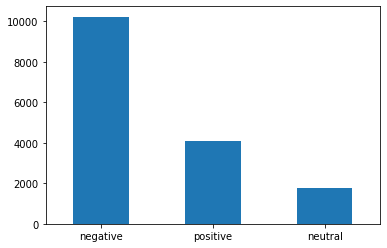

In [158]:
data['тональность'].value_counts().plot(kind="bar", rot = 0)

In [159]:
data['тональность'].value_counts()

negative    10232
positive     4076
neutral      1746
Name: тональность, dtype: int64

In [13]:
pip install pymorphy2

     |████████████████████████████████| 51kB 2.0MB/s 
     |████████████████████████████████| 7.1MB 9.9MB/s 


In [0]:
import pymorphy2

In [0]:
morph = pymorphy2.MorphAnalyzer()

In [0]:
def tokenize(text):
  regex_tokenizer = RegexpTokenizer('[а-яА-ЯЁё]+')
  words = regex_tokenizer.tokenize(text.lower())
  stop_words = set(stopwords.words("russian"))
  without_stop_words = [(morph.parse(w)[0]).normal_form for w in words if w not in stop_words and len(w) > 1]
  output = [add_part_of_speech(word) for word in without_stop_words]
  #print(output)
  return output

In [0]:
def add_part_of_speech(word):
  morph = pymorphy2.MorphAnalyzer()
  p = morph.parse(word)[0]
  word += '_' + str(p.tag.POS)
  return word

In [0]:
sentences = np.array(data['слово'].apply(lambda x : tokenize(x))) 

In [165]:
sentences[:10]

array([list(['аборт_NOUN']), list(['абортивный_ADJF']),
       list(['абракадабра_NOUN']), list(['абсурд_NOUN']),
       list(['абсурдность_NOUN']), list(['абсурдный_ADJF']),
       list(['авантюра_NOUN']), list(['авантюризм_NOUN']),
       list(['авантюрист_NOUN']), list(['авантюристический_ADJF'])],
      dtype=object)

In [0]:
import collections
counter = collections.Counter()

#считаем максимальную длину предложений, а также частоту всех слов предложений, считанных из файла 
maxlen = 0
for words in sentences:
    if len(words) > maxlen:
        maxlen = len(words)
    for word in words:
        counter[word] += 1

In [0]:
vocab_sz = len(counter) + 1 #кол-во различных слов в sentences

In [168]:
vocab_sz

12421

In [0]:
# Преобразование названий классов в матрицу двоичных чисел (нужно для keras)
def transform_to_categorical(tones_for_each, unique_tones, build_binary_matrix = True):
  tones_to_digit = []

  for tone in tones_for_each:
    tones_to_digit.append(unique_tones.index(tone))

  if build_binary_matrix:
    tones_to_digit = to_categorical(tones_to_digit, len(unique_tones))
  
  return tones_to_digit

In [0]:
# Преобразование номеров классов в названия классов
def transform_from_categorical(prediction, unique_tones):
  answers = []

  for i in range(prediction.shape[0]):
    answers.append(unique_tones[prediction[i]])

  return answers

In [0]:
# Создание единого словаря (слово -> число) для преобразования на основе списка текстов sentences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

In [0]:
X = tokenizer.texts_to_sequences(sentences) #заменяем слова каждого предложения на числа

In [0]:
X = pad_sequences(X, maxlen = maxlen) #уравниваем все предложения до размера maxlen

In [0]:
y = transform_to_categorical(data['тональность'], unique_tones.tolist())#заменяем названия тональностей на матрицу двоичных чисел

In [0]:
import gensim.downloader as api

In [177]:
model = api.load("word2vec-ruscorpora-300")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [178]:
len(model.vocab)

184973

In [0]:
EMBED_SIZE = 300
NUM_FILTERS = 512
NUM_WORDS = 3
BATCH_SIZE = 64
NUM_EPOCHS = 10

In [0]:
embedding_weights = np.zeros((vocab_sz, EMBED_SIZE))#создаём матрицу размером размерность словаря*размерность вектора слова
index = 0
sorted_counter = counter.most_common() #сортируем слова по частоте встречаемости
for word in sorted_counter:#для каждого слова из нашего словаря задаём вектор из model в матрицу
    try:
      embedding_weights[index, :] = model[word[0]] 
      index+=1     
    except KeyError:#если нет слова в словаре model
      index+=1
      pass

In [0]:
COUNT_CLASSES = len(unique_tones)

In [0]:
# Создание модели
def get_model(COUNT_CLASSES, embedding_weights):
  model = Sequential()
  model.add(Embedding(vocab_sz, EMBED_SIZE, input_length = maxlen,
                      weights = [embedding_weights],
                      trainable = True))
  model.add(SpatialDropout1D(0.2))
  model.add(Conv1D(filters = NUM_FILTERS, kernel_size = NUM_WORDS,
                  activation = "relu"))
  model.add(GlobalMaxPooling1D())
  model.add(Dense(1024))
  model.add(Dropout(0.2))
  model.add(Activation('relu'))
  
  model.add(Dense(COUNT_CLASSES, activation="softmax"))

  model.compile(optimizer = "adam", loss = "categorical_crossentropy",
                metrics = [keras_metrics.categorical_f1_score()])
  
  return model

In [45]:
pip install keras-metrics

In [0]:
import keras_metrics

In [0]:
keras_model = get_model(COUNT_CLASSES, embedding_weights)

In [184]:
keras_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 4, 300)            3726300   
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 4, 300)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 2, 512)            461312    
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
activation_6 (Activation)    (None, 1024)             

In [0]:
from sklearn.utils import shuffle

In [185]:
X_train, X_test, y_train, y_test = \
     train_test_split(X, y, test_size = 0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(12843, 4) (3211, 4) (12843, 3) (3211, 3)


In [186]:
history = keras_model.fit(X_train, y_train, batch_size = BATCH_SIZE,
                    epochs = NUM_EPOCHS,
                    callbacks=[ModelCheckpoint('drive/My Drive/keras_model.h5', save_best_only = True)],
                    validation_split = 0.2)

Train on 10274 samples, validate on 2569 samples
Epoch 1/10
10274/10274 [==============================] - 30s 3ms/step - loss: 0.8596 - f1_score: 0.7805 - val_loss: 0.8686 - val_f1_score: 0.7882
Epoch 2/10
10274/10274 [==============================] - 31s 3ms/step - loss: 0.5011 - f1_score: 0.9147 - val_loss: 0.8997 - val_f1_score: 0.7850
Epoch 3/10
10274/10274 [==============================] - 30s 3ms/step - loss: 0.2440 - f1_score: 0.9527 - val_loss: 1.1263 - val_f1_score: 0.5259
Epoch 4/10
10274/10274 [==============================] - 30s 3ms/step - loss: 0.1536 - f1_score: 0.9597 - val_loss: 1.2848 - val_f1_score: 0.7738
Epoch 5/10
10274/10274 [==============================] - 29s 3ms/step - loss: 0.1279 - f1_score: 0.9597 - val_loss: 1.2381 - val_f1_score: 0.7828
Epoch 6/10
10274/10274 [==============================] - 29s 3ms/step - loss: 0.1164 - f1_score: 0.9614 - val_loss: 1.4937 - val_f1_score: 0.5107
Epoch 7/10
10274/10274 [==============================] - 29s 3ms/ste

In [209]:
score = keras_model.evaluate(X_test, y_test)
print("Test accuracy: {:.3f}".format(score[1]))

3211/3211 [==============================] - 0s 151us/step
Test accuracy: 0.785


In [0]:
test = ['класс', 'отвратительный', 'ненавижу', 'нормально', 'люблю']

In [0]:
test_sentence = []

for word in test:
  test_sentence.append(tokenize(word))

In [212]:
test_sentence

[['класс_NOUN'],
 ['отвратительный_ADJF'],
 ['ненавидеть_INFN'],
 ['нормальный_ADJF'],
 ['любить_INFN']]

In [0]:
sequences_test = tokenizer.texts_to_sequences(test_sentence)

In [274]:
sequences_test

[[155], [8360], [7276], [990], [915]]

In [0]:
X_predict = pad_sequences(sequences_test, maxlen = X_train.shape[1])

In [0]:
prediction = keras_model.predict_classes(X_predict)

In [216]:
answers = transform_from_categorical(prediction, unique_tones.tolist()) 
answers

['positive', 'negative', 'negative', 'positive', 'positive']

# Попробуем классифицировать с помощью keras наш словарь

In [0]:
import json

In [0]:
# загружаем отзывы о телефонах из json файла
with open('drive/My Drive/review_db.json', 'r', encoding='utf-8') as f:
    review = json.load(f)

In [339]:
review[:2]

['Телефон классный. Перечисляю достоинства.\n- Не глючит, довольно шустрый\n- Офигенный дизайн (мой - черный с оранжевым - супер! серый с черным фигня =) )\n- Стандартный браузер хороший, не особо привередливые пользователи могут даже не ставить оперу =)\n- Естессна сеть 3G и WiFi\n- Аккумулятор хороший, долго держит. Я - человек, который постоянно серфит по инету и юзает приложения и у меня этот тел держит дней 6.\n- Игры и приложения идут абсолютно все (если конечно качать с нуждны разрешением экрана)\nИ еще много-много плюсов! Их мало. Можно пересчитать по пальцам.\n1) WiFi подключается к точке только на относительно близком расстоянии (но потом при удалении от точки держит в радиусе ее действия)\n2) Стандартный браузер не может загрузить ооооочень большие страницы и иногда, чтобы освободить память берет и удбирает виджеты. Но это не страшно\n3) Маркий экран, от которого спасает пленка или постоянное натирание Советую всем, кому нужен сенсорный телефон с хорошими функционалом и мощн

In [0]:
sentences_review = np.array([tokenize(text) for text in review[:10]])

In [338]:
sentences_review[:5]

array([list(['телефон_NOUN', 'классный_ADJF', 'перечислять_INFN', 'достоинство_NOUN', 'глючить_INFN', 'довольно_ADVB', 'шустрый_ADJF', 'офигенный_ADJF', 'дизайн_NOUN', 'чёрный_NOUN', 'оранжевый_ADJF', 'супер_ADJF', 'серый_ADJF', 'чёрный_NOUN', 'фигня_NOUN', 'стандартный_ADJF', 'браузер_NOUN', 'хороший_ADJF', 'особо_ADVB', 'привередливый_ADJF', 'пользователь_NOUN', 'мочь_NOUN', 'ставить_INFN', 'опера_NOUN', 'естессон_NOUN', 'сеть_NOUN', 'аккумулятор_NOUN', 'хороший_ADJF', 'долго_ADVB', 'держать_INFN', 'человек_NOUN', 'который_ADJF', 'постоянно_ADVB', 'серфита_NOUN', 'инет_VERB', 'юзаета_NOUN', 'приложение_NOUN', 'тело_NOUN', 'держать_INFN', 'день_NOUN', 'игра_NOUN', 'приложение_NOUN', 'идти_INFN', 'абсолютно_ADVB', 'качать_INFN', 'нуждный_ADJF', 'разрешение_NOUN', 'экран_NOUN', 'плюс_CONJ', 'мало_ADVB', 'пересчитать_INFN', 'палец_NOUN', 'подключаться_INFN', 'точка_NOUN', 'относительно_PREP', 'близкий_ADJF', 'расстояние_NOUN', 'удаление_NOUN', 'точка_NOUN', 'держать_INFN', 'радиус_NOUN',

In [0]:
counter_review = collections.Counter()

In [0]:
#считаем максимальную длину предложений, а также частоту всех слов предложений, считанных из файла 
maxlen_review = 0
for words in sentences_review:
    if len(words) > maxlen_review:
        maxlen_review = len(words)
    for word in words:
        counter_review[word] += 1

In [0]:
vocab_sz_sentences_review = len(counter_review) + 1

In [233]:
vocab_sz_sentences_review

445

In [0]:
test_sentence_review = []

for review_words in sentences_review:
  for word in review_words:
    test_sentence_review.append(tokenize(word))

In [333]:
test_sentence_review[:10]

[['телефон_NOUN'],
 ['классный_ADJF'],
 ['перечислять_INFN'],
 ['достоинство_NOUN'],
 ['глючить_INFN'],
 ['довольно_ADVB'],
 ['шустрый_ADJF'],
 ['офигенный_ADJF'],
 ['дизайн_NOUN'],
 ['чёрный_NOUN']]

In [0]:
sequences_test = tokenizer.texts_to_sequences(test_sentence_review)

In [0]:
sequences_test

In [0]:
X_predict = pad_sequences(sequences_test, maxlen = X_train.shape[1])

In [0]:
prediction = keras_model.predict_classes(X_predict)

In [0]:
answers = transform_from_categorical(prediction, unique_tones.tolist()) 
for i in range(0, len(answers)):
  print(str(test_sentence_review[i]) + ' ' + str(answers[i]))